In [ ]:
!pip install catboost
!pip install lightgbm

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import f_classif
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the data
data = pd.read_csv('credit_data_train.csv', encoding='utf8')
# X contains all columns except the 'class' column
X = data.drop(columns=['class'])
# y contains the label 'class' column
y = data['class']

data.head()

,sex,marital_status,current_account_balance,loan_duration,credit_history,loan_purpose,loan_value,savings_account_balance,length_of_employment,instalment_rate,...,length_of_residence,most_valuable_asset,age,other_debt_obligations,home_ownership,existing_credits,employment,num_dependants,citizenship,class
0,Female,non-single,No current account,22,Existing credits paid back,new car,1050.0,Unknown/No savings account,4-7 years,4,...,4,Savings Account/Life Insurance,25.0,None,Rent,0,Professionals,1,non-UK,0
1,Male,single,No current account,12,Existing credits paid back,new car,1900.0,Unknown/No savings account,>= 7 years,4,...,3,Car or Other,50.0,None,Own,0,Professionals,1,non-UK,0
2,Female,non-single,>= 160 GBP,21,Existing credits paid back,new car,2350.0,80 - 400 GBP,1-4 years,1,...,1,Car or Other,28.0,Bank,Own,0,Experienced professionals,1,non-UK,0
3,Female,non-single,< 0 GBP,6,Existing credits paid back,used car,1100.0,400 - 800 GBP,Unemployed,1,...,2,Savings Account/Life Insurance,23.0,None,Rent,0,Unemployed,1,non-UK,0
4,Female,non-single,< 0 GBP,18,Existing credits paid back,electronics,2550.0,< 80 GBP,1-4 years,2,...,2,Real Estate,24.0,None,Own,0,Professionals,1,non-UK,1


**Description of features:**
*   current_account_balance - The current account balance before the loan applicant applied for a loan. A negative value means an overdraft on their current accounts.
*   loan_duration - Repayment period for the loan submitted by the loan applicants (in months)
*   credit_history - Credit history with the current bank and other banks
*   loan_purpose - What the loan applicant will use the loan for
*   loan_value - The amount of loan the applicant applies (in British pound sterling)
*   savings_account_balance - The balance in the loan applicant’s savings account
*   length_of_employment - How long the loan applicant has been in their current employment
*   instalment_rate - Instalment divided by the applicant's disposable income (in percentage)
*   marital_status
*   sex
*   debtor_status - Other debtors / guarantors associated with the loan application
*   length_of_residence - How long the loan applicant has been living in the current residence
*   most_valuable_asset - The most valuable asset owned by the loan applicant
age
*   other_debt_obligations - If the loan applicant has debt with other parties
home_ownership
*   existing_credits - The number of existing credits with the bank before the loan application.
*   employment
*   num_dependants - Number of dependants
citizenship - If the loan applicant has the UK citizenship.
*   class - If the loan applicant has defaulted on their loan 0 - no, they did not default; 1 - yes, they have defaulted (only in credit_data_train.csv)

# Inspection of Data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      800 non-null    object 
 1   marital_status           800 non-null    object 
 2   current_account_balance  800 non-null    object 
 3   loan_duration            800 non-null    int64  
 4   credit_history           800 non-null    object 
 5   loan_purpose             800 non-null    object 
 6   loan_value               800 non-null    float64
 7   savings_account_balance  800 non-null    object 
 8   length_of_employment     800 non-null    object 
 9   instalment_rate          800 non-null    int64  
 10  debtor_status            800 non-null    object 
 11  length_of_residence      800 non-null    int64  
 12  most_valuable_asset      800 non-null    object 
 13  age                      792 non-null    float64
 14  other_debt_obligations   8

In [ ]:
# Check number of rows
print("Shape of training set features:", X.shape)
print("Shape of training set labels:", y.shape)

Shape of training set features: (800, 20)
Shape of training set labels: (800,)


In [ ]:
# Data type
print("The columns and their data types:")
print(X.dtypes)
print(y.dtypes)

The columns and their data types:
sex                         object
marital_status              object
current_account_balance     object
loan_duration                int64
credit_history              object
loan_purpose                object
loan_value                 float64
savings_account_balance     object
length_of_employment        object
instalment_rate              int64
debtor_status               object
length_of_residence          int64
most_valuable_asset         object
age                        float64
other_debt_obligations      object
home_ownership              object
existing_credits             int64
employment                  object
num_dependants               int64
citizenship                 object
dtype: object
int64


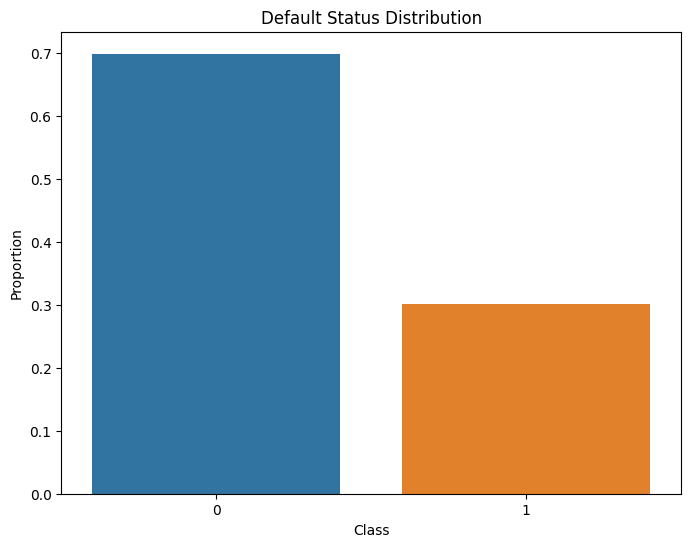

In [ ]:
# Inspect labels distribution
class_proportions = y.value_counts(normalize=True)
plt.figure(figsize=(8, 6))
sns.barplot(x=class_proportions.index, y=class_proportions.values)
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Default Status Distribution')
plt.show()

In this dataset, it looks like around 30% of the people defaulted on their loans whereas only around 70% of people did not default.The imbalanced classes suggests a bias towards the negative class (did not default).

In [ ]:
# Check for duplicates of records
print("Duplicated records: ", X.duplicated().sum())

Duplicated records:  0


In [ ]:
# Check for missing values
print("Count of missing values: ")
print(X.isnull().sum())
print(y.isnull().sum())

Count of missing values: 
sex                        0
marital_status             0
current_account_balance    0
loan_duration              0
credit_history             0
loan_purpose               0
loan_value                 0
savings_account_balance    0
length_of_employment       0
instalment_rate            0
debtor_status              0
length_of_residence        0
most_valuable_asset        0
age                        8
other_debt_obligations     0
home_ownership             0
existing_credits           0
employment                 0
num_dependants             0
citizenship                0
dtype: int64
0


Although the values for training labels are complete, it can be seen that there are some missing feature values so we need to impute them.

In [ ]:
# Examine numerical features
X.describe()

,loan_duration,loan_value,instalment_rate,length_of_residence,age,existing_credits,num_dependants
count,800.000000,800.000000,800.000000,800.000000,792.000000,800.000000,800.000000
mean,20.852500,2794.495075,2.967500,2.852500,35.633838,0.406250,1.167500
std,11.744815,3708.764599,1.123843,1.090748,11.955766,0.573692,0.753428
min,4.000000,200.000000,1.000000,1.000000,19.000000,0.000000,1.000000
25%,12.000000,1100.000000,2.000000,2.000000,27.000000,0.000000,1.000000
50%,18.000000,1850.000000,3.000000,3.000000,33.000000,0.000000,1.000000
75%,24.000000,3200.000000,4.000000,4.000000,42.000000,1.000000,1.000000
max,60.000000,59563.600000,4.000000,4.000000,131.000000,3.000000,20.000000


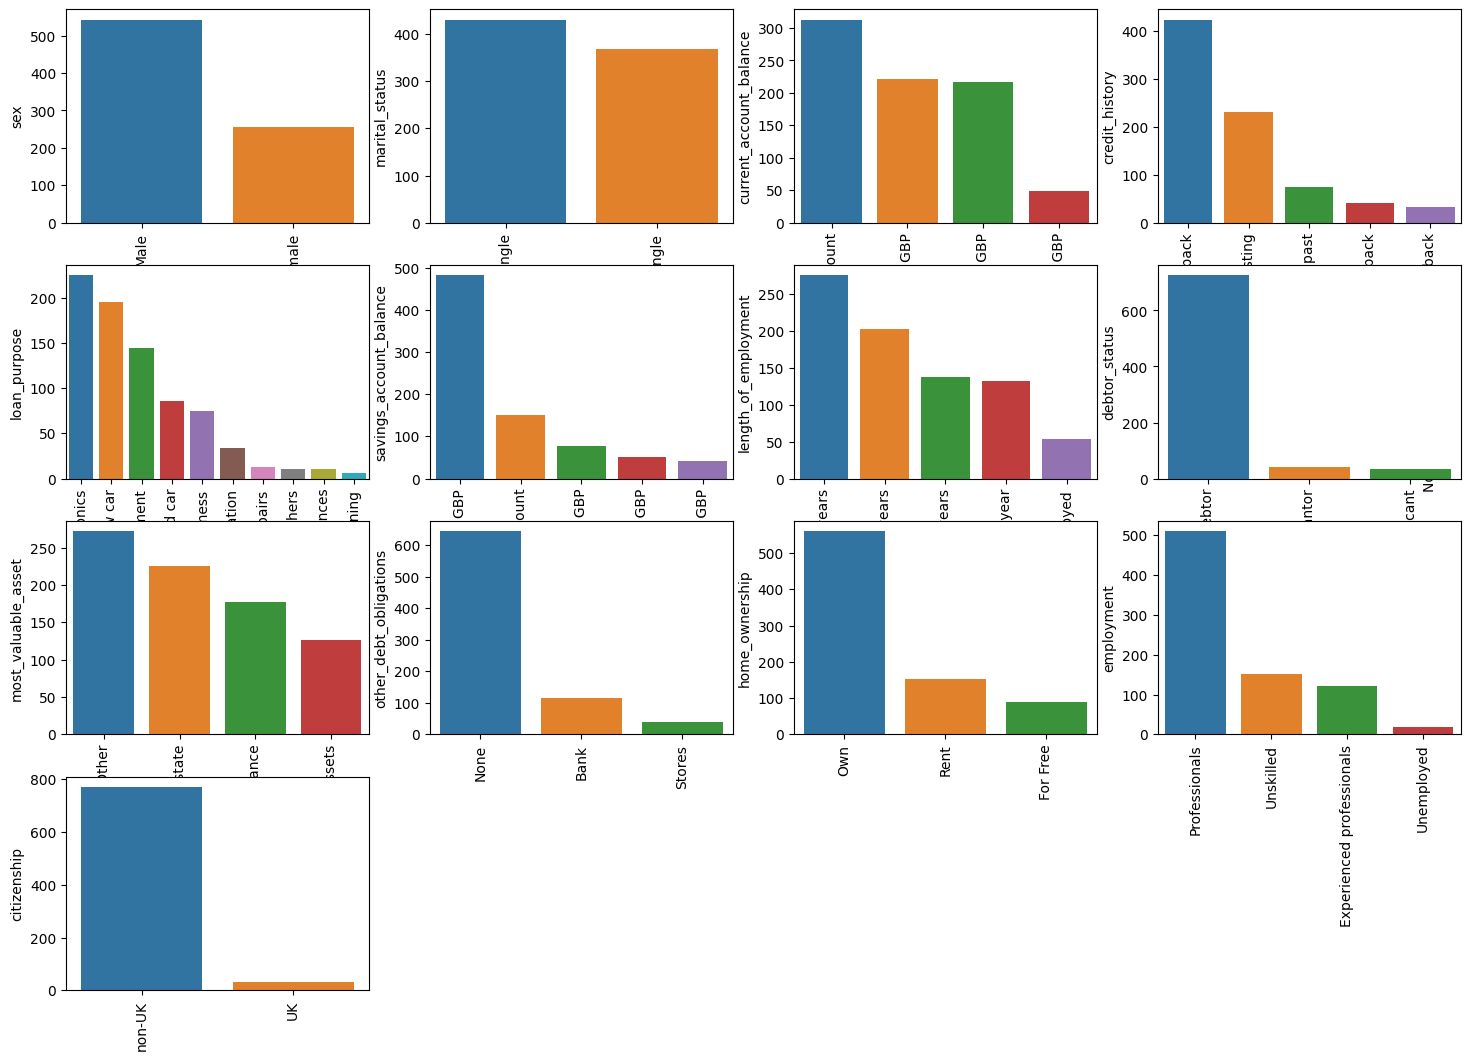

In [ ]:
# Examine the frequency distribution of categorical features
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
plt.figure(figsize=(18, 36))
index = 1

for col in object_cols:
  y_counts = data[col].value_counts()
  plt.subplot(11, 4, index)
  plt.xticks(rotation = 90)
  sns.barplot(x = list(y_counts.index), y = y_counts)
  index +=1

# Data Preprocessing

In [ ]:
# Encode ordinal features
ordinal_mappings = {
    'current_account_balance': {'< 0 GBP': 1, 'No current account': 2, '0 - 160 GBP': 3, '>= 160 GBP': 4},
    'credit_history': {'Outstanding credits existing': 1, 'Delay in paying off in the past': 2, 'Existing credits paid back': 3, 'No credits taken/All credits paid back': 3, 'All credits at this bank paid back': 3},
    'savings_account_balance': {'Unknown/No savings account': 1, '< 80 GBP': 2, '80 - 400 GBP': 3, '400 - 800 GBP': 4, '>= 800 GBP': 5},
    'length_of_employment': {'Unemployed': 1, '< 1 year': 2, '1-4 years': 3, '4-7 years': 4, '>= 7 years': 5},
    'most_valuable_asset': {'No assets': 1, 'Savings Account/Life Insurance': 2, 'Car or Other': 3, 'Real Estate': 4},
    'employment': {'Unskilled': 1, 'Unemployed': 2, 'Professionals': 3, 'Experienced professionals': 4},
}

# Apply mapping to ordinal features
for feature in ordinal_mappings:
    X[feature] = X[feature].map(ordinal_mappings[feature])

# Check ordinal mapping
# X.head()

# Seperate ordinal and nominal columns
numerical_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
other_features = [col for col in X.columns if X[col].dtype == 'object']

In [ ]:
# Create preprocessors for ordinal and nominal features separately
numerical_transformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Specify column names for OneHotEncoder
categorical_feature_names = other_features

# Apply ColumnTransformer to preprocess features
preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_transformer, numerical_features),
    ('categorical', categorical_transformer, categorical_feature_names)
])

# Transform the columns and put the column name back
X = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())

# Type cast to int for efficiency
X = X.astype('int')

# Feature Engineering

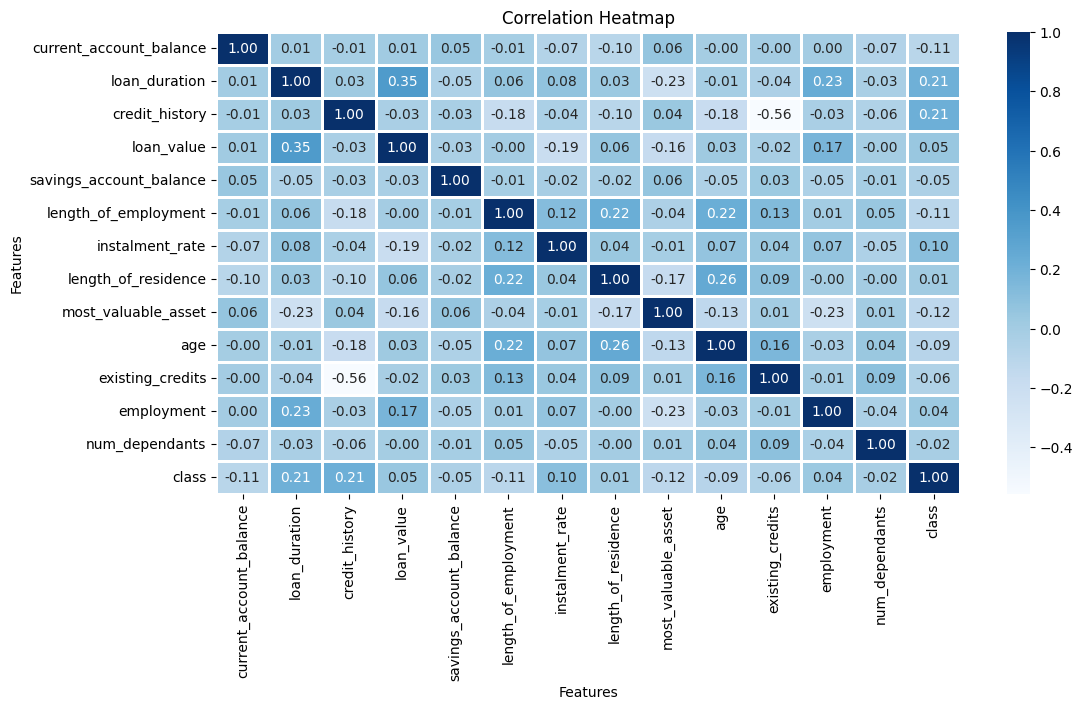

In [ ]:
plt.figure(figsize=(12, 6))

# Create the heatmap with customizations to investigate relationships
data2=data
for feature in ordinal_mappings:
    data2[feature] = data2[feature].map(ordinal_mappings[feature])

sns.heatmap(data2.corr(), cmap='Blues', annot=True, fmt='.2f', linewidths=2, annot_kws={"size": 10}, cbar=True)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Creation of new features
# X['numerical__total_savings'] = X['numerical__current_account_balance'] + X['numerical__savings_account_balance']
# X['numerical__ltv_ratio'] = X['numerical__loan_value'] / (X['numerical__current_account_balance'] + X['numerical__savings_account_balance'])

In [ ]:
# Split train and test dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y,
                                                  random_state=0)

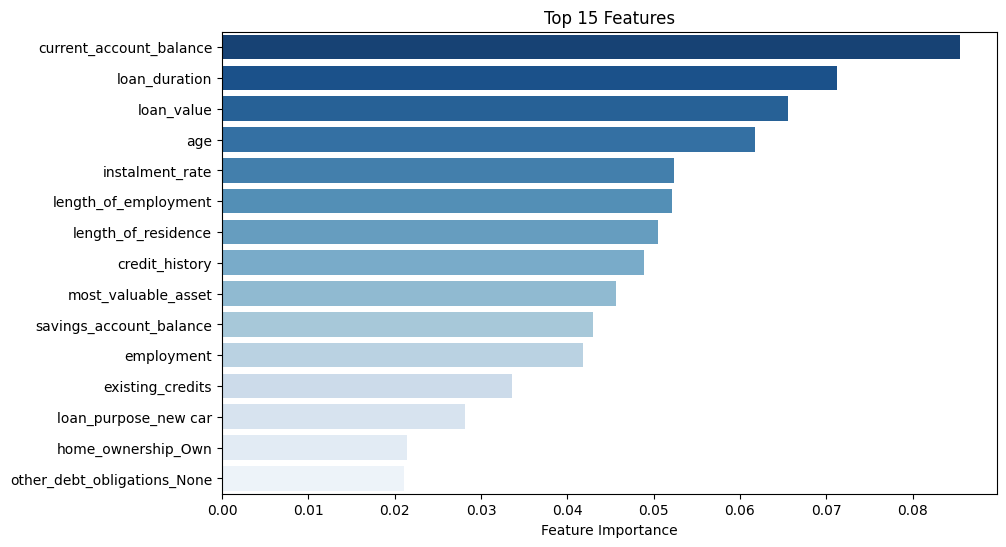

In [ ]:
# ExtraTreesClassifier feature selection method
etc = ExtraTreesClassifier(n_estimators=100, random_state=0)
etc.fit(X_train, y_train)

imp_scores = pd.Series(etc.feature_importances_, index=X_train.columns)
imp_cols = imp_scores.nlargest(37)

# Transform data to select features
# X_train_fe = X_train[imp_cols.index]
# X_val_fe = X_val[imp_cols.index]

# Plot top 15 features without labels
top_15_features = imp_cols.head(15)
top_15_features = top_15_features.rename(lambda x: x.split('__')[1])
# print("Top 15 Features and their importance scores:")
# print(top_15_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_features.values, y=top_15_features.index, palette='Blues_r')
plt.xlabel('Feature Importance')
plt.title('Top 15 Features')
plt.show()

# Modelling

In [ ]:
# Create LogisticRegression instance
model_lr = LogisticRegression(random_state=18)
# Perform cross-validation
score_lr = cross_val_score(model_lr, X_train, y_train, scoring='roc_auc', cv=5).mean()
print(f"Logistic Regression's ROC AUC score: {score_lr:.2%}")

Logistic Regression's ROC AUC score: 72.48%


In [ ]:
# Create RandomForestClassifier instance
model_rf = RandomForestClassifier(n_estimators=100, random_state=18)
score_rf = cross_val_score(model_rf, X_train, y_train, scoring='roc_auc', cv=5).mean()
print(f"Random Forest's ROC AUC score: {score_rf:.2%}")

Random Forest's ROC AUC score: 78.35%


In [ ]:
# Create LightGBMClassifier instance
model_lgbm = LGBMClassifier(n_estimators=100, max_depth=6, num_leaves=25, random_state=18)
score_lgbm = cross_val_score(model_lgbm, X_train, y_train, scoring='roc_auc', cv=5).mean()
print(f"LightGBM's ROC AUC score: {score_lgbm:.2%}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.302734 -> initscore=-0.834311
[LightGBM] [Info] Start training from score -0.834311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
# Create CatBoostClassifier instance
model_cb = CatBoostClassifier(iterations=100, depth=6, silent=True, random_state=18)
score_cb = cross_val_score(model_cb, X_train, y_train, scoring='roc_auc', cv=5).mean()
print(f"CatBoost's ROC AUC score: {score_cb:.2%}")

CatBoost's ROC AUC score: 82.15%


Dataset is imbalanced, so ROC AUC is chosen as the evaluation metric

Chose CatBoost over LightGBM, RandomForest, and LogisticRegression due to its strong performance.

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'iterations': [125, 150, 1750],
    'depth': [5, 6, 7],
    'learning_rate': [0.12, 0.13, 0.15],
    'l2_leaf_reg': [5, 6, 7],
    'subsample': [0.8, 0.9, 1]
}

model_cb = CatBoostClassifier(iterations=100, random_state=18, early_stopping_rounds=8)

# Define a GridSearchCV object with the CatBoost model, hyperparameter grid, 5-fold cross-validation
grid_search = GridSearchCV(estimator=model_cb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

# Fit the GridSearchCV on your data
grid_search.fit(X_train, y_train)

# Access the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("------------------------------------------")
print(f"Best hyperparameters using GridSearchCV: {best_params}")
print(f"\nCatBoost's ROC AUC score from cross-validation: {best_score:.2%}")
accuracy_score_val = grid_search.best_estimator_.score(X_val, y_val)
print(f"Accuracy Score on Validation Data: {accuracy_score_val:.2f}")

0:	learn: 0.6481318	total: 2.01ms	remaining: 250ms
1:	learn: 0.6088154	total: 4.78ms	remaining: 294ms
2:	learn: 0.5755564	total: 6.91ms	remaining: 281ms
3:	learn: 0.5505942	total: 8.75ms	remaining: 265ms
4:	learn: 0.5304728	total: 10.8ms	remaining: 260ms
5:	learn: 0.5156639	total: 12.6ms	remaining: 250ms
6:	learn: 0.5026340	total: 14.5ms	remaining: 244ms
7:	learn: 0.4874195	total: 16.3ms	remaining: 238ms
8:	learn: 0.4748400	total: 18ms	remaining: 232ms
9:	learn: 0.4634784	total: 19.8ms	remaining: 228ms
10:	learn: 0.4526052	total: 21.7ms	remaining: 225ms
11:	learn: 0.4463192	total: 23.4ms	remaining: 221ms
12:	learn: 0.4381991	total: 25.5ms	remaining: 220ms
13:	learn: 0.4289186	total: 27.3ms	remaining: 217ms
14:	learn: 0.4209548	total: 29.3ms	remaining: 215ms
15:	learn: 0.4139153	total: 31.1ms	remaining: 212ms
16:	learn: 0.4065913	total: 32.9ms	remaining: 209ms
17:	learn: 0.3984852	total: 34.7ms	remaining: 206ms
18:	learn: 0.3919244	total: 36.5ms	remaining: 204ms
19:	learn: 0.3864161	tot

Best hyperparameters using GridSearchCV: {'depth': 6, 'iterations': 125, 'l2_leaf_reg': 6, 'learning_rate': 0.13, 'subsample': 0.9}

# Model Submission